# Facial Recognition

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.cuda.is_available()

True

## Creating a dataset

In [6]:
dataset_path = "dataset/train"

### Transforming images.jpg in tensors

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
dataset = ImageFolder(root=dataset_path, transform=transform)

## Creating a Dataloader

In [11]:
from torch.utils.data import DataLoader, random_split
# assuming you have a 'dataset' object already defined

# define the sizes for training and validation sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int((len(dataset) - train_size)/2)  # 15% for validation
test_size = int((len(dataset) - train_size)/2)  # 15% for testing

# use random_split to create training and validation datasets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# define batch size
batch_size = 32

# create separate dataloaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
num_classes = len(dataset.classes)
print('The number of classes in the dataset are: ', num_classes)

The number of classes in the dataset are:  7000


In [13]:
for batch in train_dataloader:
    images, labels = batch
    # 'images' is a tensor containing a batch of images
    # 'labels' is a tensor containing corresponding labels (class indices)
    break 

In [14]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [15]:
labels

tensor([3973, 5727, 2658, 5298, 2275,  315, 4395, 5685, 6775, 4590, 2741, 5719,
        6228, 2450, 5923, 2561, 6652, 1907, 5237, 5961, 1067, 2532, 6435, 3918,
         351, 6405, 2816, 6760, 6624, 5936,  186, 3651])

In [16]:
images.max(), images.min()

(tensor(2.6400), tensor(-2.1179))

## Visualizing the Dataset

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

# assuming you have the ImageNet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# define unnormalize transform
unnormalize_transform = transforms.Compose([
    transforms.Normalize(mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]),
])

def show_random_images(data_loader, dataset, unnormalize, num_images=1):
    # get one batch from the DataLoader
    batch = next(iter(data_loader))
    images, labels = batch

    # select random images from the batch
    indices = np.random.choice(len(images), num_images, replace=False)

    for index in indices:
        image = images[index]  # no need to permute dimensions for displaying with matplotlib
        unnormalized_image = unnormalize(image)

        # get the corresponding label (class name) from the original dataset
        original_dataset = data_loader.dataset.dataset  # Access the original dataset from the Subset
        class_idx = int(labels[index])
        class_name = original_dataset.classes[class_idx]

        # display the unnormalized image with the label
        plt.imshow(unnormalized_image.permute(1, 2, 0))
        plt.title(f"Label: {class_name}")
        plt.axis('off')
        plt.show()

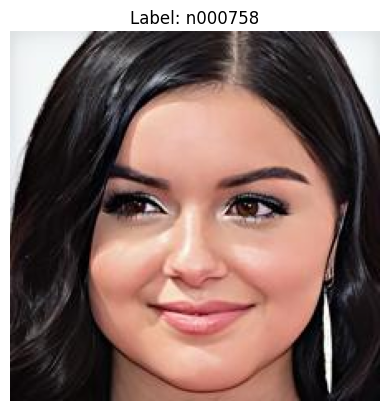

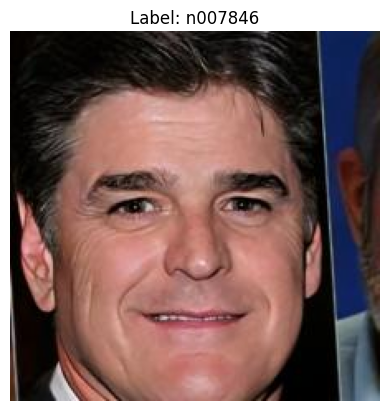

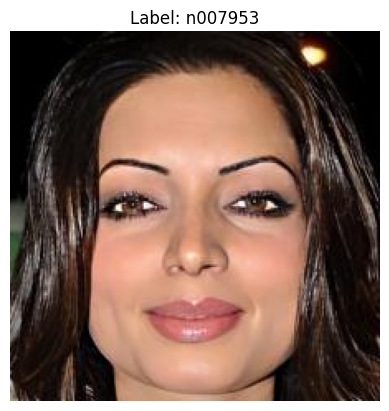

In [17]:
# example usage:
show_random_images(train_dataloader, train_dataset, unnormalize_transform, num_images=3)

## Creating a model

In [17]:
checkpoint = torch.load('rnet_best.pth')

# print the keys in the checkpoint dictionary
print(checkpoint.keys())

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 7000)
# load the saved model state dictionary
checkpoint = torch.load('rnet_best.pth')

# load the model state dictionary
model.load_state_dict(checkpoint)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

## Training Loop

In [122]:
# empty variables to store training and validation loss and accuracy values
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    # Training stage
    model.train()

    # empty variables to store training loss and accuracy in current epoch   
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    #  iterate over the training data loader
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_samples

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

    # save loss and accuracy values for training
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    # validation stage
    model.eval()  # set the model to evaluation mode

    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)

            # calculate accuracy
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

            val_running_loss += val_loss.item()

    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_epoch_accuracy = val_correct_predictions / val_total_samples

    print(f"Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")

    # save loss and accuracy values for validation
    val_loss_history.append(val_epoch_loss)
    val_accuracy_history.append(val_epoch_accuracy)

print("Training complete!")


Epoch 1/10, Train Loss: 2.6255, Train Accuracy: 0.4803
Epoch 1/10, Val Loss: 2.4203, Val Accuracy: 0.5185
Epoch 2/10, Train Loss: 2.6222, Train Accuracy: 0.4808
Epoch 2/10, Val Loss: 2.4029, Val Accuracy: 0.5215
Epoch 3/10, Train Loss: 2.6179, Train Accuracy: 0.4818
Epoch 3/10, Val Loss: 2.3966, Val Accuracy: 0.5228
Epoch 4/10, Train Loss: 2.6220, Train Accuracy: 0.4808
Epoch 4/10, Val Loss: 2.4198, Val Accuracy: 0.5206
Epoch 5/10, Train Loss: 2.6233, Train Accuracy: 0.4804
Epoch 5/10, Val Loss: 2.4103, Val Accuracy: 0.5223
Epoch 6/10, Train Loss: 2.6222, Train Accuracy: 0.4819
Epoch 6/10, Val Loss: 2.4212, Val Accuracy: 0.5175
Epoch 7/10, Train Loss: 2.6222, Train Accuracy: 0.4809
Epoch 7/10, Val Loss: 2.4095, Val Accuracy: 0.5203
Epoch 8/10, Train Loss: 2.6214, Train Accuracy: 0.4809
Epoch 8/10, Val Loss: 2.4272, Val Accuracy: 0.5177
Epoch 9/10, Train Loss: 2.6218, Train Accuracy: 0.4817
Epoch 9/10, Val Loss: 2.4098, Val Accuracy: 0.5209
Epoch 10/10, Train Loss: 2.6252, Train Accurac

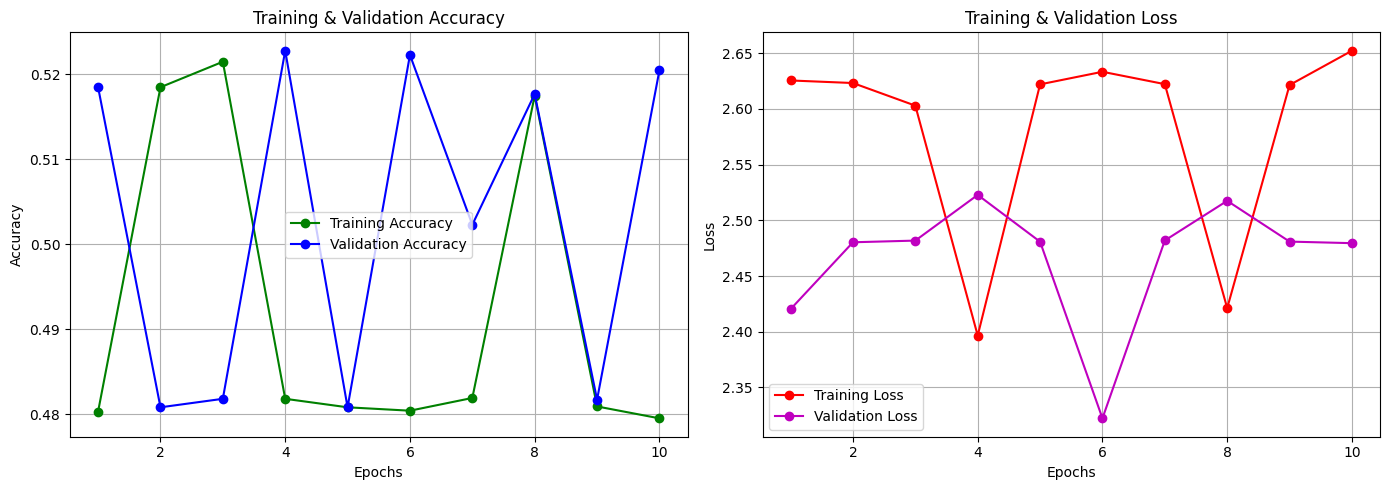

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# plot training and validation accuracy
axes[0].plot(10, train_accuracy_history, 'g-o', label='Training Accuracy')
axes[0].plot(10, val_accuracy_history, 'b-o', label='Validation Accuracy')
axes[0].set_title('Training & Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# plot training and validation loss
axes[1].plot(10, train_loss_history, 'r-o', label='Training Loss')
axes[1].plot(10, val_loss_history, 'm-o', label='Validation Loss')
axes[1].set_title('Training & Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# show the plot
plt.tight_layout()
plt.show()

In [21]:

# set the model to evaluation mode
model.eval()

# variables to store the number of correct predictions and total samples
correct_predictions = 0
total_samples = 0

# iterate over the test dataloader
for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)

    # forward pass through the model
    outputs = model(images)

    # get the predicted labels
    _, predicted = torch.max(outputs, 1)

    # count the number of correct predictions
    correct_predictions += (predicted == labels).sum().item()

    # count the total number of samples
    total_samples += labels.size(0)

# calculate the test accuracy
test_accuracy = correct_predictions / total_samples

print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.5285


## Testing

In [ ]:
test_dataset_path = "dataset/test"

In [32]:
import csv
import os
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import numpy as np

def process_and_classify(dataset_path, output_file):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # image normalization parameters
    normalization_mean = [0.485, 0.456, 0.406]
    normalization_std = [0.229, 0.224, 0.225]

    # transformation for validation dataset
    validation_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(normalization_mean, normalization_std)
    ])

    # Load dataset and model
    dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), validation_transforms)
    class_names = dataset.classes
    total_classes = len(class_names)
    trained_model = models.resnet50(pretrained=True)
    trained_model.fc = nn.Linear(trained_model.fc.in_features, total_classes)
    # trained_model.load_state_dict(torch.load(model_path, map_location=device))
    checkpoint = torch.load('best_model_checkpoint.pth')

# load the model state dictionary
    trained_model.load_state_dict(checkpoint)
    trained_model.to(device)
    trained_model.eval()

    # prediction function
    def predict(image_file):
        image = Image.open(image_file).convert('RGB')
        image_tensor = validation_transforms(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = trained_model(image_tensor)
            _, preds = torch.max(output, 1)
            return class_names[preds[0]]

    # iterate over test images and classify
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['image_name', 'label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        test_images_dir = os.path.join(dataset_path, 'test')
        for image_filename in os.listdir(test_images_dir):
            if image_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                label = predict(os.path.join(test_images_dir, image_filename))
                writer.writerow({'image_name': image_filename, 'label': label})
                print(f"Classified {image_filename} as {label}")

    print(f"Classifications written to {output_file}")

# call the function with your dataset and model paths
dataset_directory = 'dataset'
checkpoint_path = 'rnet_best.pth'
predictions_csv = 'test_predictionsv5.csv'
process_and_classify(dataset_directory, predictions_csv)

/home/sule/miniconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sule/miniconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classified 1.jpg as n007982
Classified 10.jpg as n007555
Classified 100.jpg as n005193
Classified 1000.jpg as n008281
Classified 10000.jpg as n008817
Classified 10001.jpg as n004771
Classified 10002.jpg as n004509
Classified 10003.jpg as n003581
Classified 10004.jpg as n001978
Classified 10005.jpg as n003880
Classified 10006.jpg as n007562
Classified 10007.jpg as n002884
Classified 10008.jpg as n003208
Classified 10009.jpg as n008052
Classified 1001.jpg as n002321
Classified 10010.jpg as n008157
Classified 10011.jpg as n005801
Classified 10012.jpg as n000876
Classified 10013.jpg as n008908
Classified 10015.jpg as n005198
Classified 10016.jpg as n008212
Classified 10017.jpg as n001057
Classified 10018.jpg as n009133
Classified 10019.jpg as n003983
Classified 1002.jpg as n001392
Classified 10020.jpg as n004528
Classified 10021.jpg as n002558
Classified 10022.jpg as n002089
Classified 10023.jpg as n000875
Classified 10024.jpg as n009015
Classified 10025.jpg as n000597
Classified 10026.jpg